<a href="https://colab.research.google.com/github/Joan-yy/AnxietyLevelPrediction/blob/main/Copy_of_IDS_GA2_XGBoostClassifier_Corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing Required Libraries

In [ ]:
# importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
)
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
import joblib

# 2. Load Dataset from Google Drive

In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Read dataset from the directory in google drive
df=pd.read_csv('/content/drive/MyDrive/enhanced_anxiety_dataset.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# import dataset from google drive
from google.colab import drive
drive.mount('/content/drive')

# Load dataset
df = pd.read_csv('/content/drive/MyDrive/Year2Sem2/Dataset/enhanced_anxiety_dataset.csv')

Mounted at /content/drive


# 3. Categorize Anxiety Levels

In [ ]:
# Define function to categorize anxiety level
def map_anxiety_level(score):
    if score <= 3.0:
        return "Low"
    elif score <= 7.0:
        return "Medium"
    else:
        return "High"

# Create a categorical target column
df['Anxiety_Category'] = df['Anxiety Level (1-10)'].apply(map_anxiety_level)

# Drop the old numeric anxiety score (if present)
df = df.drop(['Anxiety Level (1-10)'], axis=1, errors='ignore')

# 4. Feature Encoding

In [ ]:
# Binary columns (Yes/No or Male/Female)
binary_cols = ['Gender', 'Smoking', 'Family History of Anxiety', 'Dizziness', 'Medication', 'Recent Major Life Event']
for col in binary_cols:
    df[col] = df[col].map({'Yes': 1, 'No': 0, 'Male': 1, 'Female': 0})

# One-hot encode multi-category columns like 'Occupation'
df = pd.get_dummies(df, columns=['Occupation'], drop_first=True)

# Drop any remaining rows with missing values
df = df.dropna()

# 5. Split Dataset (Train/Test)

In [ ]:
# Separate features and target
X = df.drop('Anxiety_Category', axis=1)
y = df['Anxiety_Category']

# Encode target to numeric
y_encoded = y.map({'Low': 0, 'Medium': 1, 'High': 2})
class_names = ['Low', 'Medium', 'High']  # Needed for confusion matrix/ROC

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

# 6. Model Training

In [ ]:
# Train XGBoost model
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42,)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:54:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

# 7. Model Evaluation


--- Model Performance ---
Accuracy: 0.7848443843031123
F1 Score (macro): 0.8396229929493347
AUC ROC Score (macro-averaged): 0.9086494800620127

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.79      0.78      1032
           1       0.77      0.73      0.75       990
           2       0.99      0.99      0.99       195

    accuracy                           0.78      2217
   macro avg       0.84      0.84      0.84      2217
weighted avg       0.79      0.78      0.78      2217



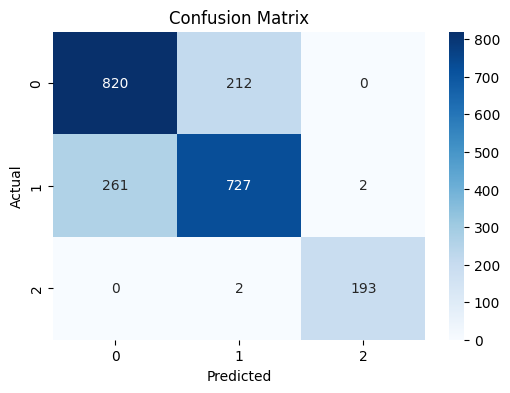

In [ ]:
# Predict on test set
y_pred = model.predict(X_test)

# Encode target labels for AUC calculation (must be numeric)
le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)
y_pred_encoded = le.transform(y_pred)

print("\n--- Model Performance ---")

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# F1 Score (macro for multiclass)
f1 = f1_score(y_test, y_pred, average='macro')
print("F1 Score (macro):", f1)

# AUC ROC (macro average for multiclass)
# Need probabilistic predictions
y_proba = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test_encoded, y_proba, multi_class='ovr', average='macro')
print("AUC ROC Score (macro-averaged):", roc_auc)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=le.classes_)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



# 8. Hyperparameter Tuning (RandomizedSearchCV)

In [ ]:
# Define parameter distributions
param_dist = {
    'max_depth': randint(3, 10),
    'n_estimators': randint(50, 300),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)

# Random search
random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist,
                                   n_iter=30, scoring='f1_macro', cv=3, verbose=1, n_jobs=-1, random_state=42)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_
print("Best Hyperparameters:", random_search.best_params_)


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Hyperparameters: {'colsample_bytree': np.float64(0.722213395520227), 'learning_rate': np.float64(0.11753971856328177), 'max_depth': 3, 'n_estimators': 77, 'subsample': np.float64(0.958931027762678)}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [05:56:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


# 9. Tuned Model Evaluation


--- Tuned Model Performance ---
Accuracy : 0.8069463238610736
F1‑score : 0.8538653889662196
ROC‑AUC : 0.9228251715909984

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80      1032
           1       0.79      0.77      0.78       990
           2       0.98      0.98      0.98       195

    accuracy                           0.81      2217
   macro avg       0.85      0.85      0.85      2217
weighted avg       0.81      0.81      0.81      2217



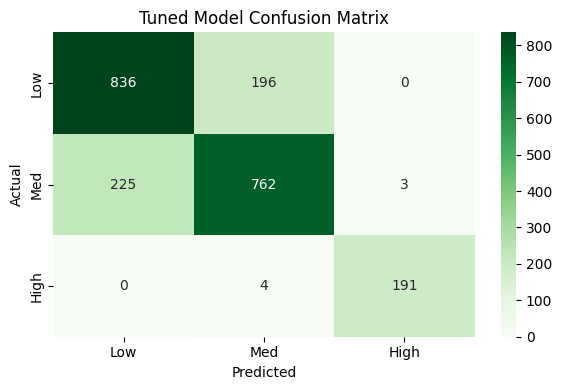

In [ ]:
y_pred_best = best_model.predict(X_test)
y_proba_best = best_model.predict_proba(X_test)

print("\n--- Tuned Model Performance ---")
print("Accuracy :", accuracy_score(y_test, y_pred_best))
print("F1‑score :", f1_score(y_test, y_pred_best, average="macro"))
print(
    "ROC‑AUC :",
    roc_auc_score(y_test, y_proba_best, multi_class="ovr", average="macro"),
)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))

# Updated Confusion Matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Greens", xticklabels=["Low", "Med", "High"], yticklabels=["Low", "Med", "High"])
plt.title("Tuned Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 10. Persist Best Model

In [ ]:
#Save the best model
joblib.dump(model, 'model.pkl')

# Save columns to use in Streamlit app
joblib.dump(X.columns.tolist(), 'model_features.pkl')

from google.colab import files
files.download('model.pkl')
files.download('model_features.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>